In [1]:
setwd('/import/a.jif/')

In [2]:
options(future.globals.maxSize= 1000*1024^2)

In [3]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [4]:
MSC = readRDS('./MSC.after_ano.rds')

In [7]:
B=readRDS('./final_Bcell.rds')

In [8]:
T = readRDS('./scrna.anno2.rds')

In [9]:
sce1 = merge(MSC,merge(T,B))

In [10]:
ifnb.list <- SplitObject(sce1, split.by = "group")
testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)
DefaultAssay(testAB.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)
testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)
immune.combined = testAB.integrated

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12741 anchors

Filtering anchors

	Retained 3138 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16956
Number of edges: 624600

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 15
Elapsed time: 4 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
02:21:18 UMAP embedding parameters a = 0.9922 b = 1.112

02:21:18 Read 16956 rows and found 30 numeric columns

02:21:18 Using Annoy for neighbor search, n_neighbors = 30

02:21:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:21:19 Writing NN index file to temp file /tmp/RtmprrnNEN/file3ab1577c21d00

02:21:19 Searching Annoy index using 1 thread, search_k = 3000

02:21:24 Annoy recall = 100%

02:21:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

In [11]:
table(sce1$celltype)


          B         MSC          NK      Prof_T    TCL_GZMB T_CD4_naive 
        406         194        2258        1043        1485        3120 
 Tcell_GZMK        Treg      plasma 
       5912        1371        1167 

In [12]:
library(CellChat)
library(patchwork)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'patchwork' was built under R version 4.2.3"


In [13]:
DefaultAssay(sce1) = 'RNA'

In [14]:
Idents(sce1) = 'group'

In [15]:
table(sce1$group)


  Con Tumor 
 3799 13157 

In [16]:
Idents(sce1) = 'group'
wt = subset(sce1,idents = 'Con')
ko = subset(sce1,idents = 'Tumor')

In [17]:
cellchat <- createCellChat(object = wt,
                           meta = wt@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human 
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=10)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 


Warning message in createCellChat(object = wt, meta = wt@meta.data, group.by = "celltype"):
"The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 
"


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B, MSC, NK, Prof_T, TCL_GZMB, T_CD4_naive, Tcell_GZMK, Treg, plasma 


An object of class CellChat created from a single dataset 
 27984 genes.
 3799 cells. 
CellChat analysis of single cell RNA-seq data! 

Warning message:
"package 'future' was built under R version 4.2.3"

Attaching package: 'future'


The following objects are masked from 'package:igraph':

    %->%, %<-%




The number of highly variable ligand-receptor pairs used for signaling inference is 645 


In [18]:
cellchat <- smoothData(cellchat, adj = PPI.human)

In [19]:
#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
library(future)
options(future.globals.maxSize= 400000000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-09-04 02:29:06]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-09-04 02:32:07]"


In [20]:
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 5)
df.net <- subsetCommunication(cellchat)

In [21]:
cellchat <- aggregateNet(cellchat)
#计算每种细胞各有多少个
groupSize <- as.numeric(table(cellchat@idents))

In [22]:

par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Interaction weights/strength")

ERROR: Error in weight.scale == TRUE: comparison (1) is possible only for atomic and list types


In [23]:
mat <- cellchat@net$count
par(mfrow = c(3,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  # i = 1
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                    arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_number_individual.pdf
## 运行上述代码出现报错 Error in plot.new() : figure margins too large
# par("mar")
## [1] 5.1 4.1 4.1 2.1
# par(mar=c(1,1,1,1))
# 重新运行上面的代码

ERROR: Error in weight.scale == TRUE: comparison (1) is possible only for atomic and list types


In [24]:
mat <- cellchat@net$weight
par(mfrow = c(3,3), xpd=T)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                   arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_strength_individual.pdf

ERROR: Error in weight.scale == TRUE: comparison (1) is possible only for atomic and list types


In [25]:
mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=T)
for (i in 1:nrow(mat)) {
      mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
      mat2[i, ] <- mat[i, ]
      netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                       arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
    }
# save as TIL/net_strength_individual.pdf

ERROR: Error in weight.scale == TRUE: comparison (1) is possible only for atomic and list types


In [26]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

In [27]:
cellchat@netP$pathways  #查看都有哪些信号通路
# [1] "TGFb"       "NRG"        "PDGF"       "CCL"        "CXCL"       "MIF"        "IL2"        "IL6"       
# [9] "IL10"       "IL1"        "CSF"        "IL16"       "IFN-II"     "LT"         "LIGHT"      "FASLG"     
# [17] "TRAIL"      "BAFF"       "CD40"       "VISFATIN"   "COMPLEMENT" "PARs"       "FLT3"       "ANNEXIN"   
# [25] "GAS"        "GRN"        "GALECTIN"   "BTLA"       "BAG"     
# 选择其中一个信号通路，比如说TGFb


[1] "MIF"      "PARs"     "CypA"     "MK"       "TNF"      "TGFb"    
 [7] "PTN"      "CXCL"     "IL16"     "LIGHT"    "IFN-II"   "CD40"    
[13] "BAG"      "ANGPTL"   "FASLG"    "VISFATIN" "GAS"      "PDGF"    
[19] "IGF"

In [28]:
pathways.show <- cellchat@netP$pathways

[1] "B"           "MSC"         "NK"          "Prof_T"      "TCL_GZMB"   
[6] "T_CD4_naive" "Tcell_GZMK"  "Treg"        "plasma"

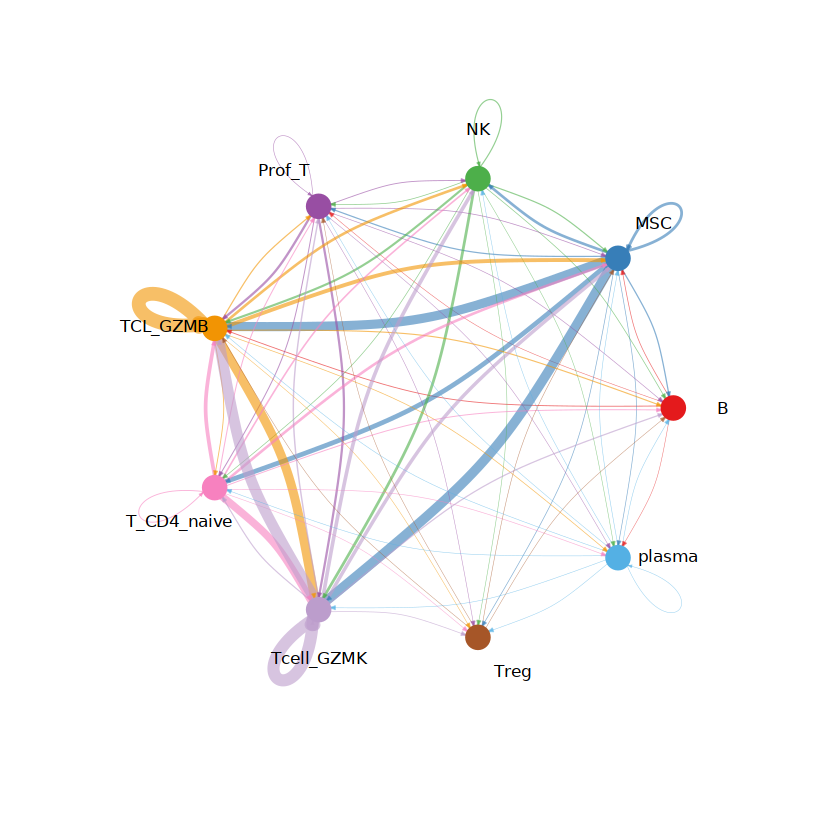

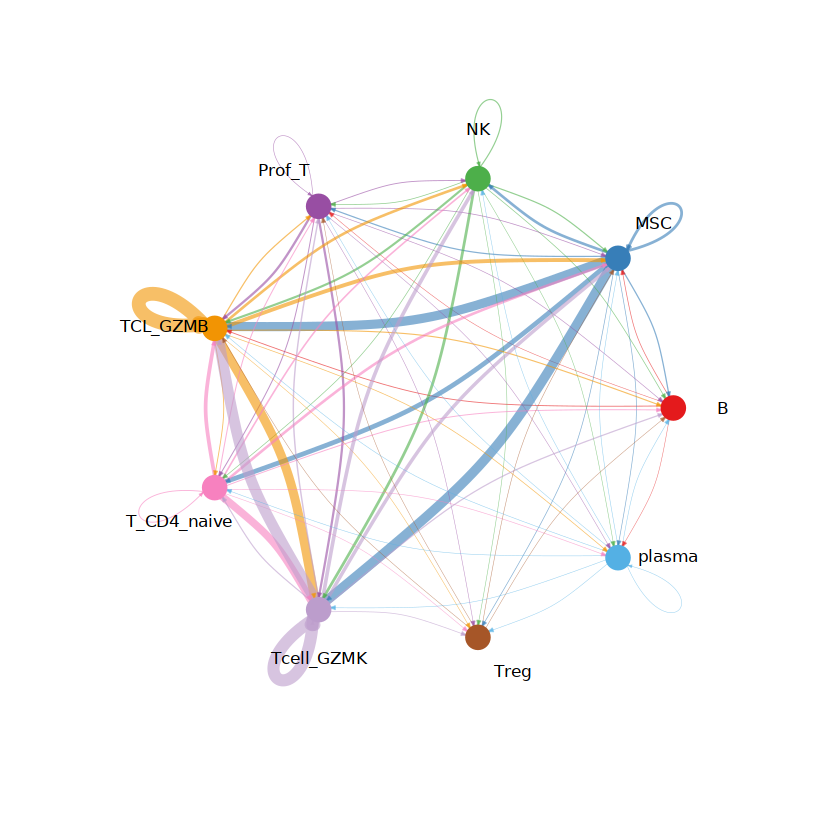

In [29]:
levels(cellchat@idents)    # show all celltype
# [1] "Naive CD4 T"  "Memory CD4 T" "CD14+ Mono"   "B"            "CD8 T"       
# [6] "FCGR3A+ Mono" "NK"           "DC"           "Platelet"    
vertex.receiver = c(1,2,4,6) # define a numeric vector （淋系细胞）giving the index of the celltype as targets
#par(mar=c(5.1,4.1,4.1,2.1))
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy.pdf

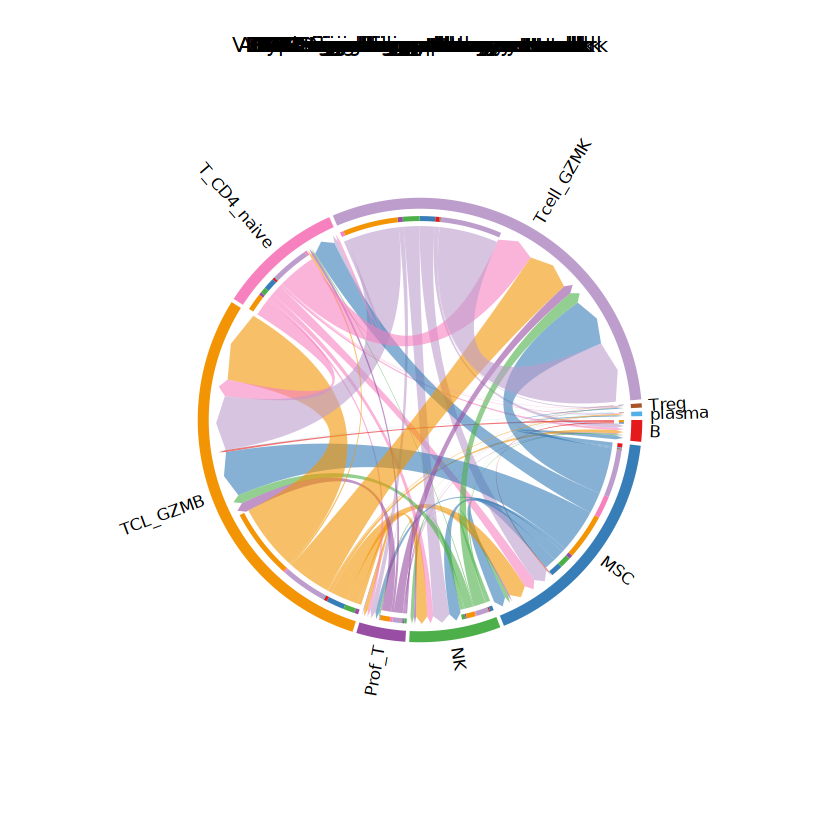

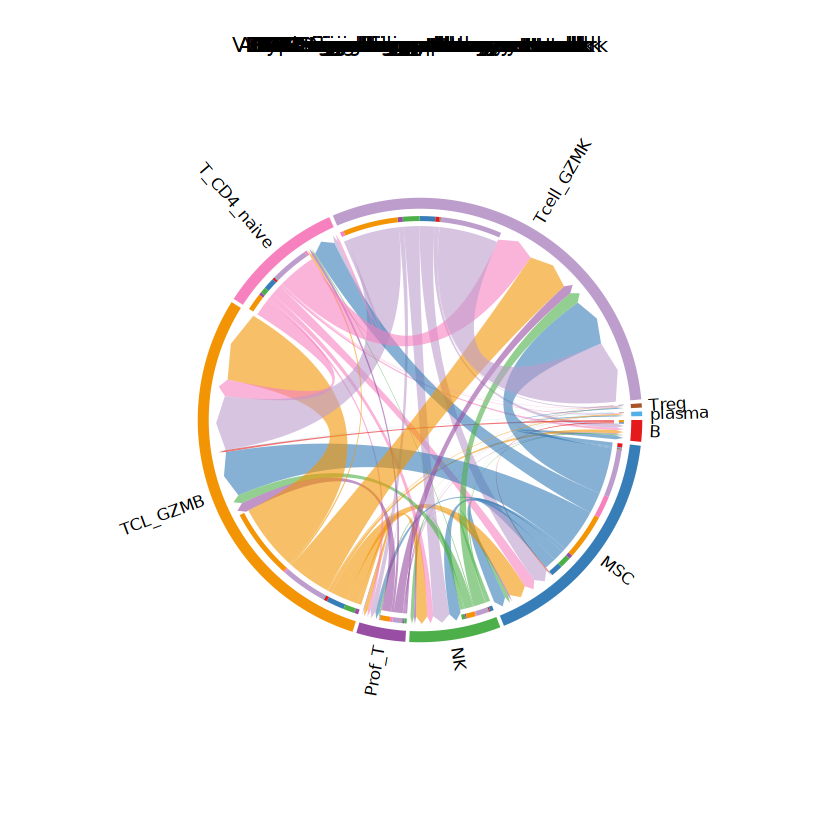

In [30]:
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
# save as TIL/CXCL_chord.pdf

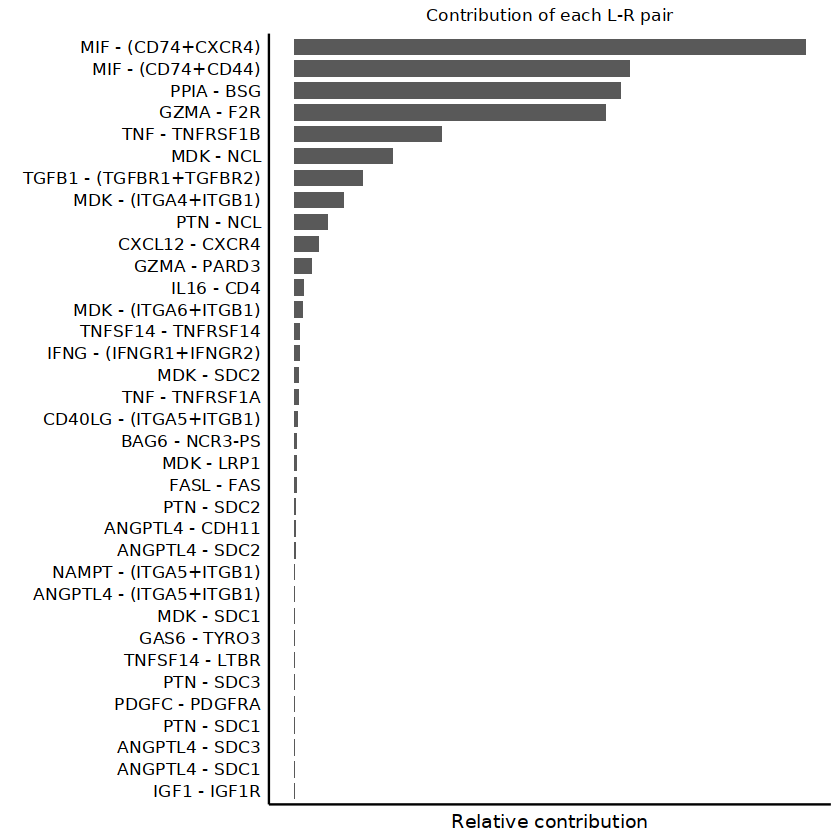

In [31]:
#计算配体受体对选定信号通路的贡献值（在这里就是查看哪条信号通路对TGFb贡献最大）
netAnalysis_contribution(cellchat, signaling = pathways.show)
pairLR.TGFb <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE) #提取对TGFb有贡献的所有配体受体 
# save as TIL/CXCL_LR_contribution.pdf

[[1]]


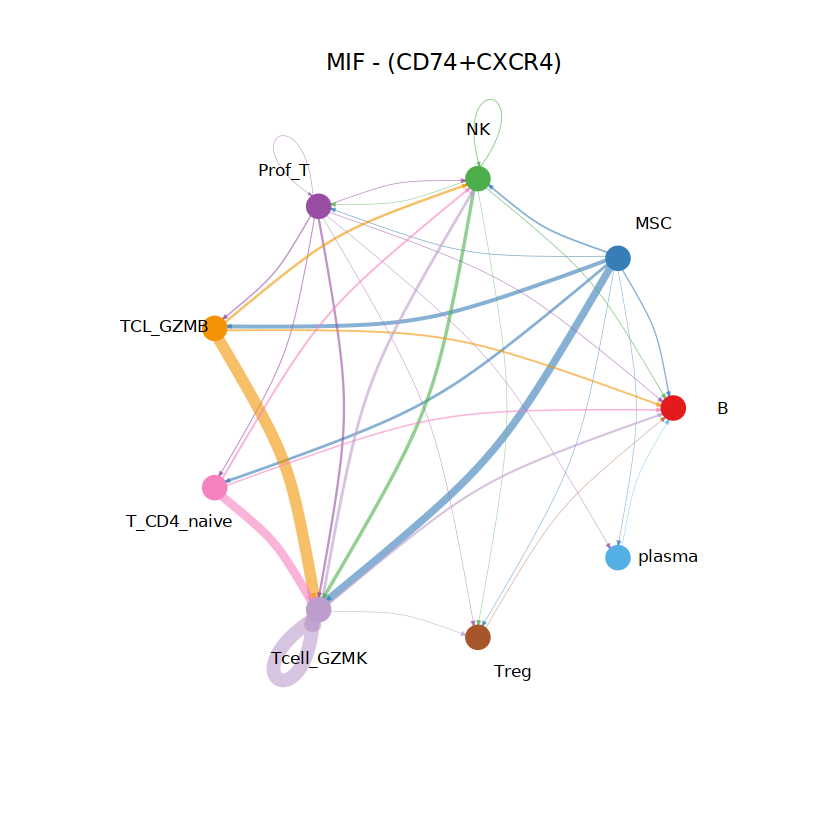

In [32]:
#提取对这个通路贡献最大的配体受体对来展示（也可以选择其他的配体受体对）
LR.show <- pairLR.TGFb[1,] 
vertex.receiver = c(1,2,4,6) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy2.pdf

In [33]:
levels(cellchat@idents)
# show all the significant interactions (L-R pairs)
#需要指定受体细胞和配体细胞
p = netVisual_bubble(cellchat, sources.use = c(3,5,7,8,9), 
                     targets.use = c(1,2,4,6), remove.isolate = FALSE)
#ggsave("Mye_Lymph_bubble.pdf", p, width = 8, height = 12) #髓系对淋巴的调节
# save as TIL/Mye_Lymph_bubble.pdf

[1] "B"           "MSC"         "NK"          "Prof_T"      "TCL_GZMB"   
[6] "T_CD4_naive" "Tcell_GZMK"  "Treg"        "plasma"

Comparing communications on a single object 




In [34]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

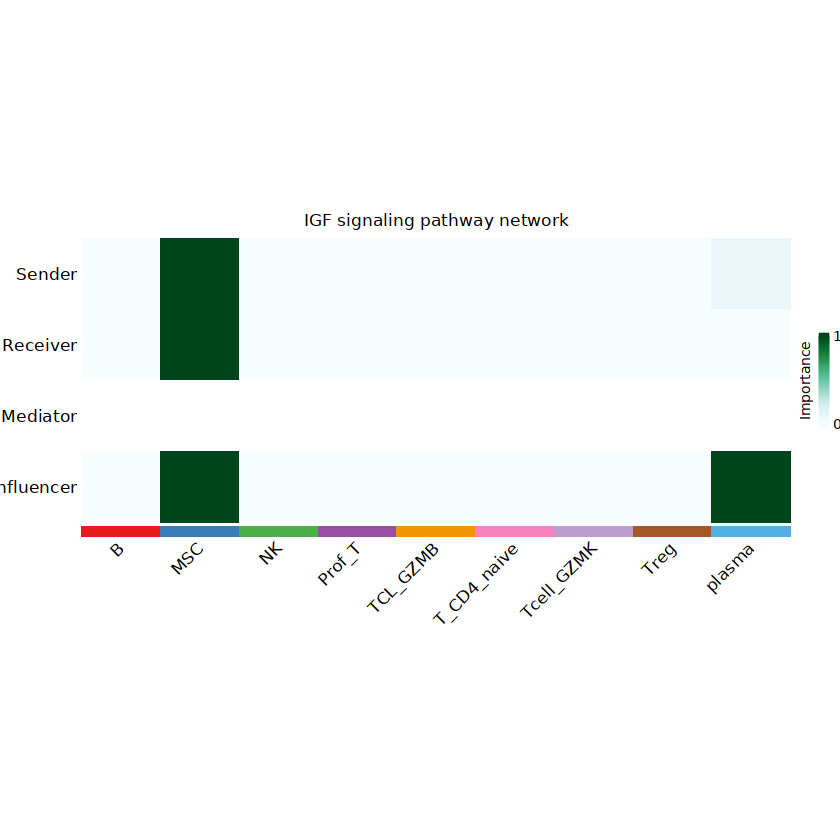

In [35]:
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                   width = 15, height = 6, font.size = 10)
# # save as TIL/SNA_CXCL_signalingRole.pdf

In [36]:
write.csv(df.net, "cell-cell_communications.all.wt.remove.dc.csv")
saveRDS(cellchat,file =  'wt.cellchat.removedc.rds')

In [37]:
wt

An object of class Seurat 
27984 features across 3799 samples within 1 assay 
Active assay: RNA (27984 features, 0 variable features)

In [38]:
ko

An object of class Seurat 
27984 features across 13157 samples within 1 assay 
Active assay: RNA (27984 features, 0 variable features)

In [39]:
cellchat <- createCellChat(object = ko,
                           meta = ko@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=15)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B, MSC, NK, Prof_T, TCL_GZMB, T_CD4_naive, Tcell_GZMK, Treg, plasma 


An object of class CellChat created from a single dataset 
 27984 genes.
 13157 cells. 
CellChat analysis of single cell RNA-seq data! 

The number of highly variable ligand-receptor pairs used for signaling inference is 751 


In [40]:
#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- smoothData(cellchat, adj = PPI.human)
library(future)
options(future.globals.maxSize= 4000000000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 5)
df.net <- subsetCommunication(cellchat)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-09-04 03:08:10]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-09-04 03:16:31]"
The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  MSC ! 	26.9% interactions are removed!


In [41]:
cellchat <- aggregateNet(cellchat)

In [42]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat@netP$pathways#查看都有哪些信号通路
# [1] "TGFb"       "NRG"        "PDGF"       "CCL"        "CXCL"       "MIF"        "IL2"        "IL6"       
# [9] "IL10"       "IL1"        "CSF"        "IL16"       "IFN-II"     "LT"         "LIGHT"      "FASLG"     
# [17] "TRAIL"      "BAFF"       "CD40"       "VISFATIN"   "COMPLEMENT" "PARs"       "FLT3"       "ANNEXIN"   
# [25] "GAS"        "GRN"        "GALECTIN"   "BTLA"       "BAG"     
# 选择其中一个信号通路，比如说TGFb
pathways.show <- cellchat@netP$pathways 

[1] "GALECTIN" "CCL"      "MIF"      "CypA"     "CXCL"     "IL16"    
 [7] "TNF"      "LT"       "LIGHT"    "FASLG"    "BAFF"     "CD70"    
[13] "BAG"

In [43]:
write.csv(df.net, "cell-cell_communications.all.ko.removedc.csv")
saveRDS(cellchat,file =  'ko.cellchat.removedc.rds')